In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Question one

Question 1: Binary classification
Given the simulated data set of N = 373 samples X 289 normalized genes (see file 2024BioinfoFTE_ML_dat.csv), build a model to predict ‘BM_label’. The goal is to achieve high specificity at sensitivity 90 – meaning at least 90% of M correctly classified as M. Please provide your code and generate a report (for example: R markdown, Python Notebook) that contains:
• A summary of your model building process: cross validation procedure, feature engineering, models tested, parameter tuning method, etc.
• A table of cross-validated performance metrics, including AUC, specificity at sensitivity 90% and the corresponding cutoff.
• Any plots that help the reviewer to understand the performance and challenging (i.e., misclassified) samples or subtypes (see column ‘Subtype_label’).

In [128]:
# read in the data

df = pd.read_csv('2024BioinfoFTE_ML_dat.csv')

df.head()

print ("The number of rows in the data is: ", df.shape[0])
print ("The number of columns in the data is: ", df.shape[1])

df.head()


The number of rows in the data is:  373
The number of columns in the data is:  292


,sampleid,BM_label,Subtype_label,Gexp_1,Gexp_2,Gexp_3,Gexp_4,Gexp_5,Gexp_6,Gexp_7,...,Gexp_280,Gexp_281,Gexp_282,Gexp_283,Gexp_284,Gexp_285,Gexp_286,Gexp_287,Gexp_288,Gexp_289
0,BFN_1,B,BFN,2.012434,6.475739,7.403382,5.079842,6.661414,11.420208,5.697739,...,11.902200,7.346017,10.707870,7.080375,8.287987,7.507218,7.156346,6.000984,7.817179,7.302311
1,BFN_2,B,BFN,4.325741,9.022011,6.324592,3.856342,6.781965,15.406112,4.908473,...,10.422510,5.935734,8.212138,7.856388,5.858044,8.980339,12.761671,5.585948,7.648573,6.853544
2,BFN_3,B,BFN,5.215917,5.643612,6.382952,3.576874,5.105527,12.934769,5.786740,...,12.692533,7.077989,6.680264,6.319670,5.872043,6.680947,7.189723,7.127622,8.516764,8.129248
3,BFN_4,B,BFN,3.416560,7.975687,5.887156,7.928302,5.476066,15.321428,6.571551,...,10.237433,5.682980,7.351598,6.103229,5.138584,7.158227,9.593462,7.622466,8.359069,7.720262
4,BFN_5,B,BFN,3.590157,5.804780,4.327424,5.267657,7.317374,9.534488,5.015600,...,9.954924,7.577532,7.939585,7.829138,5.272358,8.287598,11.172290,6.945891,8.536443,7.115096


In [129]:
# Exploratory Data Analysis

# Check for missing values

print ("The number of missing values in the data is: ", df.isnull().sum().sum())

# subset to only the columns that are needed for the analysis
#get column indexs of 4 and beyond

df_exp = df.iloc[:, 3:]

# get the sample labels
labels = df['BM_label']



#mmake a dataframe of the scaled data
df_scaled = pd.DataFrame(df_exp, columns = df_exp.columns)
df_scaled.head()






The number of missing values in the data is:  0


,Gexp_1,Gexp_2,Gexp_3,Gexp_4,Gexp_5,Gexp_6,Gexp_7,Gexp_8,Gexp_9,Gexp_10,...,Gexp_280,Gexp_281,Gexp_282,Gexp_283,Gexp_284,Gexp_285,Gexp_286,Gexp_287,Gexp_288,Gexp_289
0,2.012434,6.475739,7.403382,5.079842,6.661414,11.420208,5.697739,7.942475,8.867197,3.273019,...,11.902200,7.346017,10.707870,7.080375,8.287987,7.507218,7.156346,6.000984,7.817179,7.302311
1,4.325741,9.022011,6.324592,3.856342,6.781965,15.406112,4.908473,9.008780,10.263855,4.804582,...,10.422510,5.935734,8.212138,7.856388,5.858044,8.980339,12.761671,5.585948,7.648573,6.853544
2,5.215917,5.643612,6.382952,3.576874,5.105527,12.934769,5.786740,8.566084,9.258508,4.117158,...,12.692533,7.077989,6.680264,6.319670,5.872043,6.680947,7.189723,7.127622,8.516764,8.129248
3,3.416560,7.975687,5.887156,7.928302,5.476066,15.321428,6.571551,9.708258,9.557745,3.327622,...,10.237433,5.682980,7.351598,6.103229,5.138584,7.158227,9.593462,7.622466,8.359069,7.720262
4,3.590157,5.804780,4.327424,5.267657,7.317374,9.534488,5.015600,9.482265,9.058336,4.145752,...,9.954924,7.577532,7.939585,7.829138,5.272358,8.287598,11.172290,6.945891,8.536443,7.115096


First, make a heatmap to see the view the correlation of the expression features

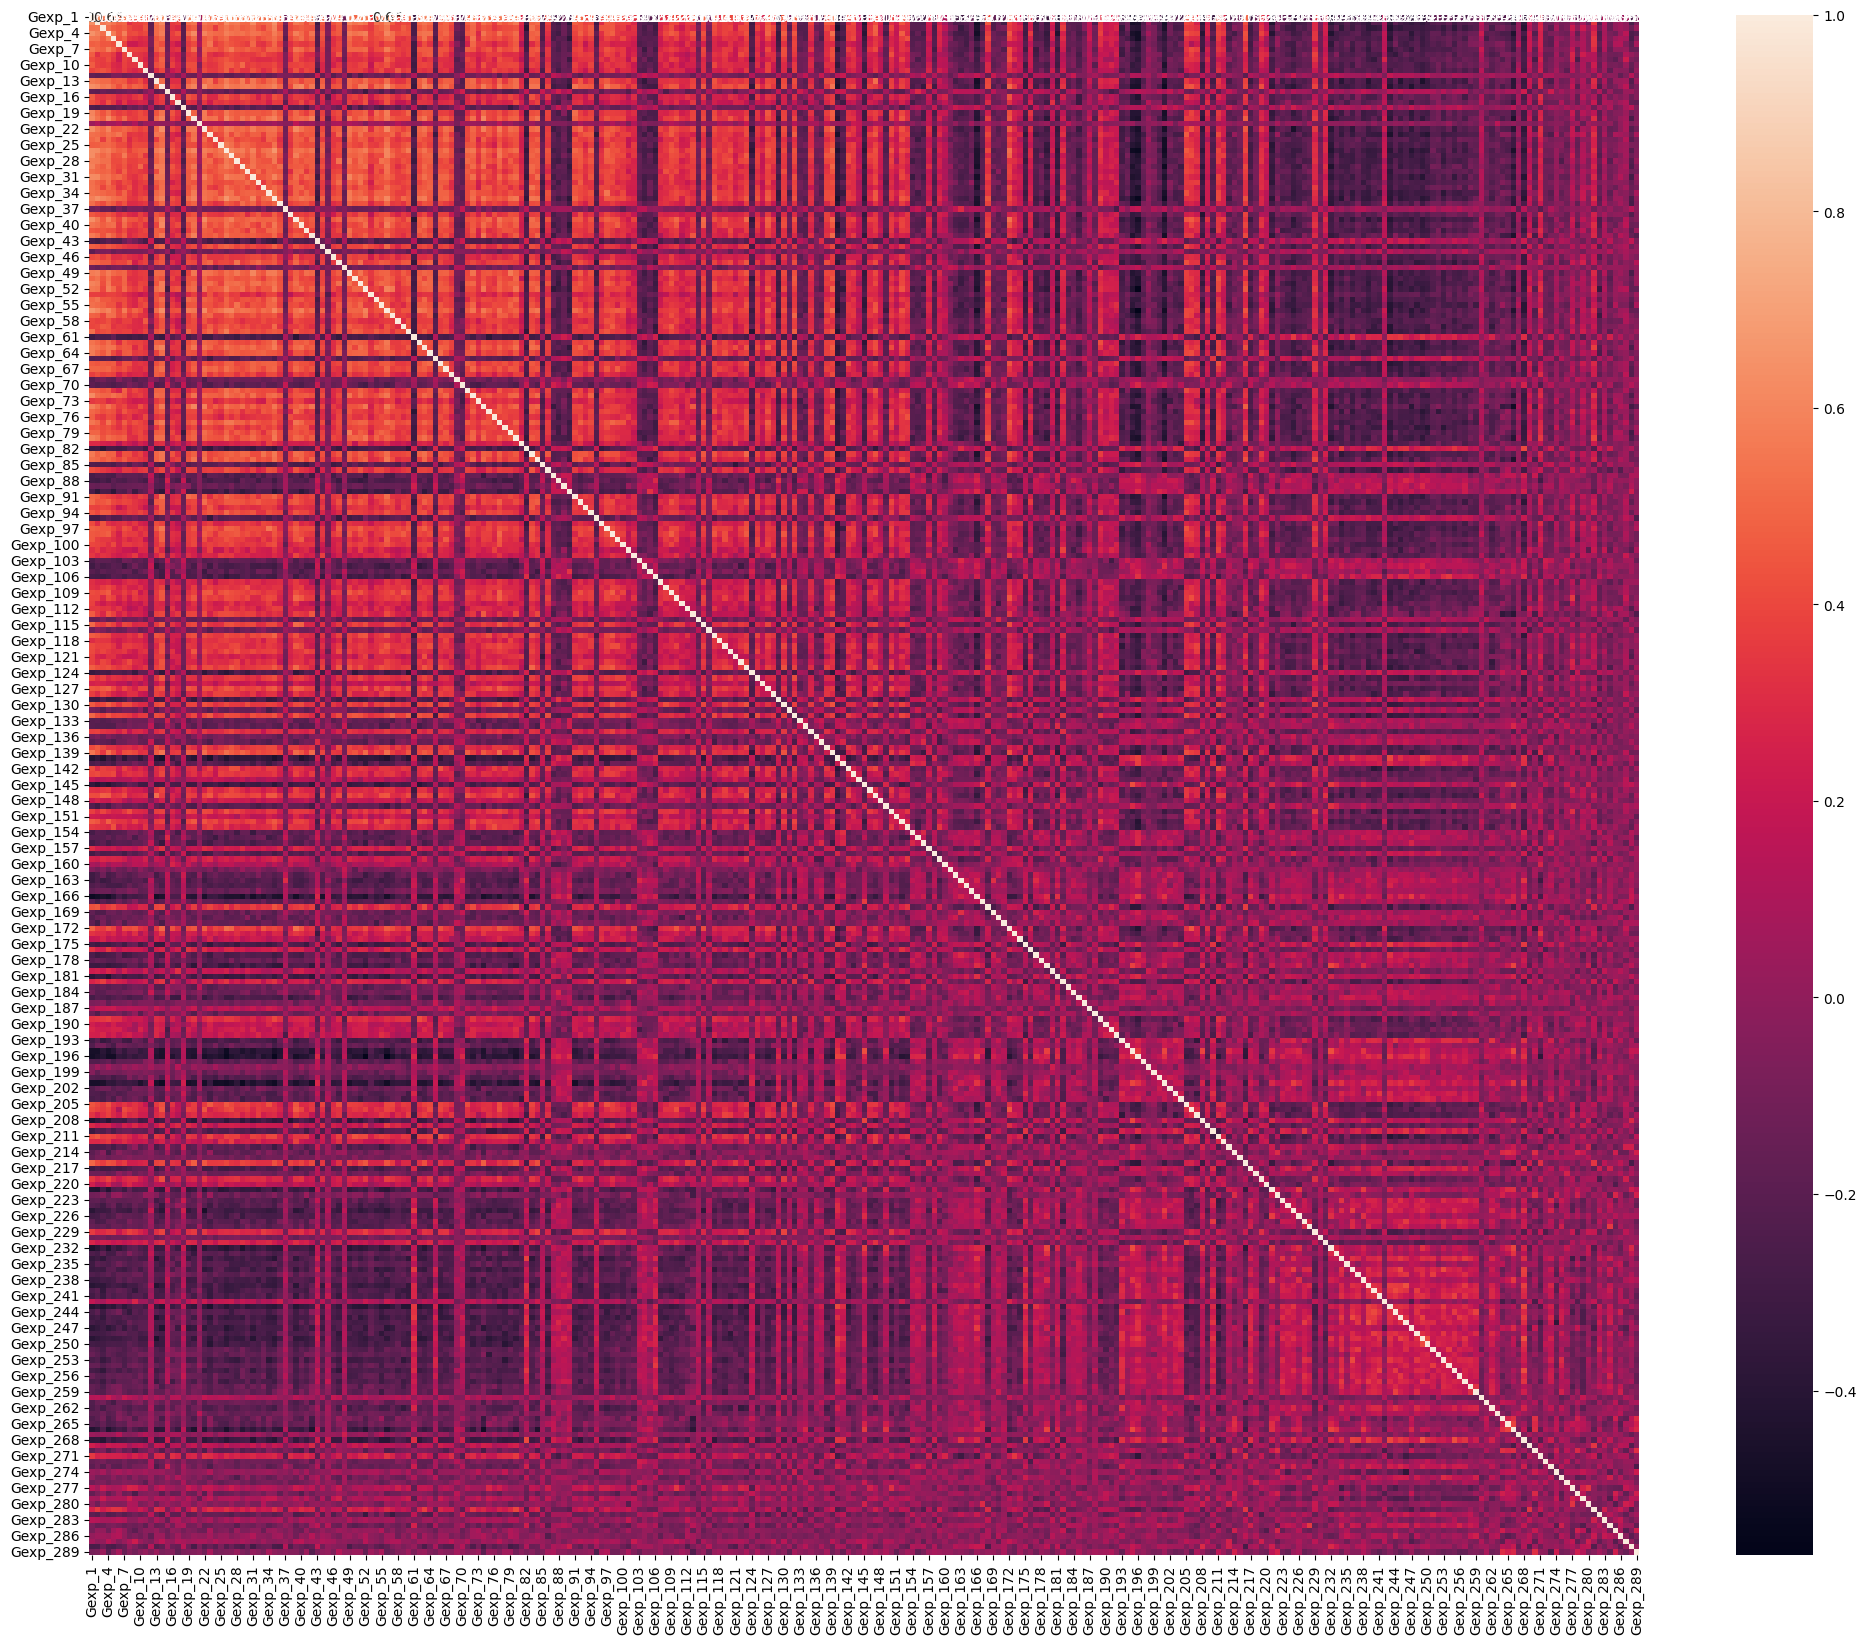

In [130]:
fig=plt.figure(figsize=(25,20))
sns.heatmap(df_exp.corr(),annot=True)
plt.show()

Since there some strong patterns of correlation among the features, we will use PCA to reduce the dimensionality of the data. We will then use the reduced data to train a logistic regression model. 

Heatmap suggests there is correlation amongst the 289 genes in the experiment

Text(0, 0.5, 'Explained variance (%)')

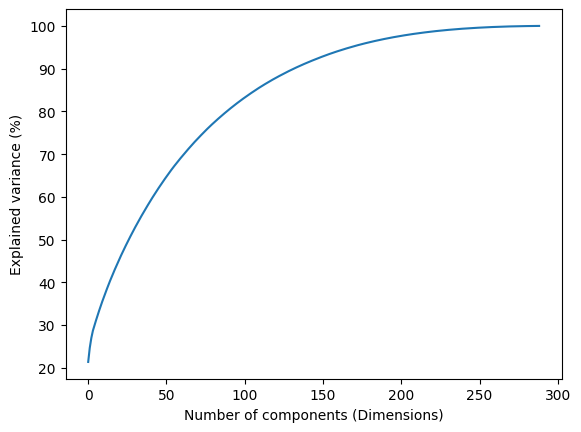

In [131]:
# scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_exp)

# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
pca.fit(df_scaled)

# Make the scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")

From the plot above, we can see that as you add more components, the explained variance increases. We will use 50 components to train the model. The question how many components to use is a hyperparameter that can be tuned.

Below we make pipeline to peform grid search on number PCA comoponents to use in Logistic regression. We will do 10 fold cross validation to find the best number of components to use.

In [132]:


from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Load your dataset


# Define PCA and Logistic Regression as part of a pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('logistic', LogisticRegression(max_iter=1000))
])

# Define a range of number of components to evaluate
param_grid = {
    'pca__n_components': range(1, 10)
}

# Perform grid search with cross-validation
grid = GridSearchCV(pipe, param_grid, cv=10, scoring='accuracy')
grid.fit(df_exp, labels)

# Print the best number of components and corresponding score
print("Best Number of Components:", grid.best_params_['pca__n_components'])
print("Best Cross-Validation Score:", grid.best_score_)


Best Number of Components: 1
Best Cross-Validation Score: 0.9178520625889046


In [133]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.406502,0.251282,0.027619,0.031025,1,{'pca__n_components': 1},0.815789,0.684211,0.894737,1.0,0.972973,1.0,0.918919,1.0,0.945946,0.945946,0.917852,0.095080,1
1,0.096367,0.094974,0.002496,0.001956,2,{'pca__n_components': 2},0.815789,0.684211,0.894737,1.0,0.972973,1.0,0.918919,1.0,0.945946,0.945946,0.917852,0.095080,1
2,0.184681,0.319795,0.002224,0.001472,3,{'pca__n_components': 3},0.710526,0.684211,0.868421,1.0,0.972973,1.0,0.945946,1.0,0.972973,0.945946,0.910100,0.112834,3
3,0.421031,0.525356,0.002198,0.001212,4,{'pca__n_components': 4},0.684211,0.736842,0.894737,1.0,0.972973,1.0,0.972973,1.0,0.810811,0.918919,0.899147,0.110530,8
4,0.083543,0.032677,0.003464,0.003162,5,{'pca__n_components': 5},0.710526,0.736842,0.894737,1.0,0.972973,1.0,0.972973,1.0,0.810811,0.918919,0.901778,0.105584,6
5,0.073177,0.043999,0.001557,0.000206,6,{'pca__n_components': 6},0.710526,0.736842,0.894737,1.0,0.972973,1.0,0.972973,1.0,0.810811,0.918919,0.901778,0.105584,6
6,0.070030,0.024038,0.001851,0.000828,7,{'pca__n_components': 7},0.684211,0.736842,0.894737,1.0,0.972973,1.0,0.972973,1.0,0.837838,0.918919,0.901849,0.108651,5
7,0.058031,0.012427,0.001455,0.000134,8,{'pca__n_components': 8},0.710526,0.736842,0.921053,1.0,0.972973,1.0,0.972973,1.0,0.837838,0.918919,0.907112,0.103600,4
8,0.060023,0.019182,0.002621,0.002379,9,{'pca__n_components': 9},0.710526,0.736842,0.894737,1.0,0.972973,1.0,0.972973,1.0,0.810811,0.891892,0.899075,0.105456,9


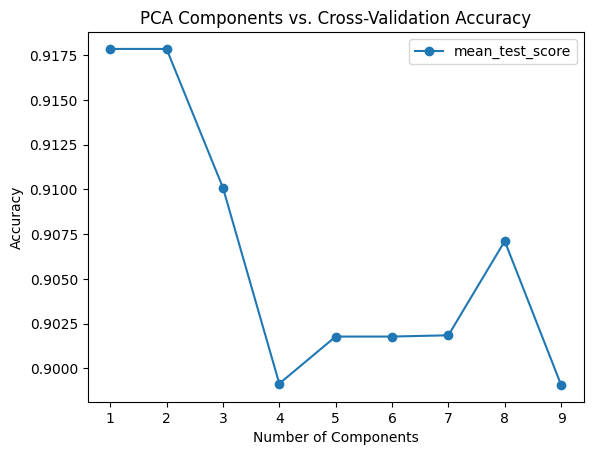

In [134]:
#make a plot of cross validation score vs number of components

results = pd.DataFrame(grid.cv_results_)
results.plot('param_pca__n_components', 'mean_test_score', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('PCA Components vs. Cross-Validation Accuracy')
plt.show()


The plot suggests that we can use 2 components and achieve a high level of accuracy. We will use 2 components to train the model. The question how many components to use is a hyperparameter that can be tuned.

[[53  3]
 [ 2 17]]
Sensitivity: 0.8947368421052632
Specificity: 0.9464285714285714
ROC AUC Score: 0.9614661654135338


Text(0.5, 1.0, 'ROC Curve')

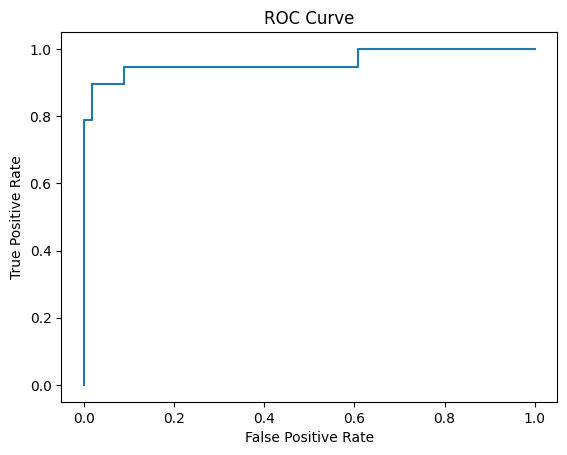

In [135]:
# construct a the final pipeline with the best number of components n=2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('logistic', LogisticRegression(max_iter=1000))
])




X_train, X_test, y_train, y_test = train_test_split(df_exp, labels, test_size=0.2, random_state=42)

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

# calculate the confusion matrix

from sklearn.metrics import confusion_matrix
y_pred = pipe.predict(X_test)
print(confusion_matrix(y_test, y_pred))

#print the confusion matrix

# calculate tp, tn, fp, fn
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)



# calculate the roc auc score
from sklearn.metrics import roc_auc_score

y_pred_prob = pipe.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_prob)


print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))

# plot the roc curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label='M')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")




|          |   |
|----------|---|
|          |   |
| new test |   |
|          |   |
|          |   |

|          |   |
|----------|---|
|          |   |
| new test |   |
|          |   |
|          |   |



## Principal Components Logistic Regression  results


| Metric | Value |
|--------|-------|
| Sensitivity    | 0.895  |
| Specificity | 0.946 |
| ROC AUC Score | 0.960 |

Based on the results here, the PCA logistic regression model is able to achieve a high level of sensitivity and specificity. The ROC AUC score is also high, indicating that the model is able to distinguish between the two classes well.

We can examine the loadings to see which genes are contributing to the principal components. 



In [136]:
pca=PCA(n_components=2)
X_pca=pca.fit_transform(X_train)

loadings=pca.components_

#gene_list
gene_list=df.columns[3:]

for i, component in enumerate(loadings):
    print("Principal Component", i+1)
    print("Top 5 genes contributing to this component:")
    print(gene_list[np.argsort(component)[-5:]])
    


Principal Component 1
Top 5 genes contributing to this component:
Index(['Gexp_64', 'Gexp_63', 'Gexp_56', 'Gexp_1', 'Gexp_5'], dtype='object')
Principal Component 2
Top 5 genes contributing to this component:
Index(['Gexp_240', 'Gexp_262', 'Gexp_259', 'Gexp_244', 'Gexp_258'], dtype='object')


We can see the boxplot of feature Gexp 64 and compare between the labels. 

We can see that the distribution of Gexp 64 is different between the two classes, supports the idea that this feature is important for classification.


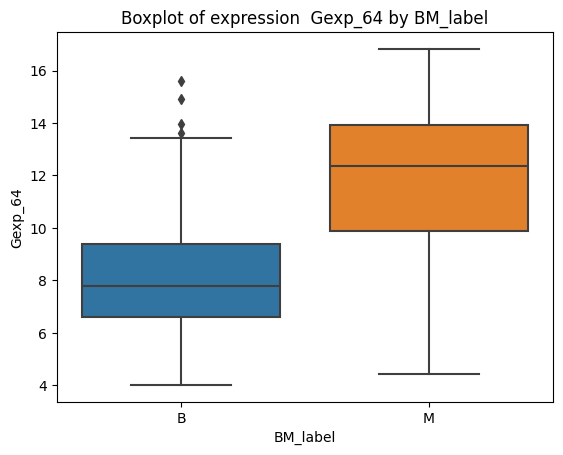

In [137]:
# plot the scattter box plot of B and M for Gexp_64
sns.boxplot(x='BM_label', y='Gexp_64', data=df)
plt.xlabel('BM_label')
plt.ylabel('Gexp_64')
plt.title('Boxplot of expression  Gexp_64 by BM_label')
plt.show()

One challenge in this model is it's difficult to interpret the model in terms of biology. The principal components are linear combinations of the original features. Examining the loadings can give some insight, but it may be difficult to interpret the model in terms of biological mechanisms between the two classes of samples.

## Nearest centroid classification

Another model that we can try is the nearest centroid classification. This model is simple and interpretable. It calculates the centroid of each class and assigns a new sample to the class with the closest centroid. The Veracyte [Prosigna](https://www.prosigna.com) test uses this method to classify breast cancer samples. It was originally developed by [Tibshirani et al.](https://www.pnas.org/doi/full/10.1073/pnas.082099299).

The centroid is the geometric center of a distribution, like the mean. Here we have 289 features, so the centroid is a point in 289-dimensional space. The nearest centroid classification calculates the distance between a new sample and the centroids of each class, and assigns the sample to the class with the closest centroid.

The method described in the original paper discusses a shrinkage value, where the centroids are shrunk towards the overall mean of the datset. The variables what are shrunk to the value of the overall mean are considered uninformative. Thus, the shrinkage value can be used to select the most informative features and can be tuned as a hyperparameter. 

We will use 10 fold cross validation to tune the shrinkage value across a grid of shrinkage values. We will then use the best shrinkage value to train the model and evaluate the performance.



In [138]:
from sklearn.datasets import load_iris
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestCentroid
from sklearn.model_selection import GridSearchCV



# Define Nearest Centroid classifier as part of a pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('nc', NearestCentroid())
])

# Define a range of shrink thresholds to evaluate
param_grid = {
    'nc__shrink_threshold': [None, .5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6 ]
}

# Perform grid search with cross-validation
grid = GridSearchCV(pipe, param_grid, cv=10, scoring='accuracy')
grid.fit(df_exp, labels)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", grid.best_params_)
print("Best Cross-Validation Score:", grid.best_score_)


Best Hyperparameters: {'nc__shrink_threshold': 2}
Best Cross-Validation Score: 0.9261735419630158


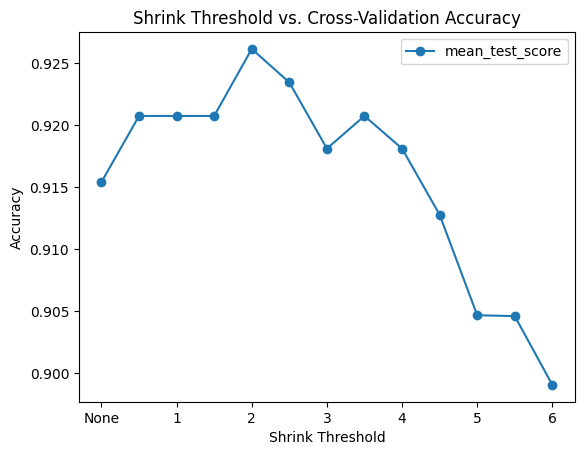

In [139]:
#make a plot of cross validation score vs shrink threshold

results = pd.DataFrame(grid.cv_results_)
results.plot('param_nc__shrink_threshold', 'mean_test_score', marker='o')
plt.xlabel('Shrink Threshold')
plt.ylabel('Accuracy')
plt.title('Shrink Threshold vs. Cross-Validation Accuracy')
plt.show()

 Based on the results of the grid search, the best shrink threshold is 1.5 with a cross-validation accuracy of 0.75. The plot of shrink threshold vs. cross-validation accuracy shows that the accuracy is highest at a shrink threshold of 1.5 and decreases as the shrink threshold increases. This indicates that the Nearest Centroid classifier performs best with a shrink threshold of 2 on this dataset.

In [140]:
# construct a the final pipeline with the shrink threshold 2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
pipe = Pipeline([
    ('scaler', StandardScaler()),
     ('nc', NearestCentroid(shrink_threshold=2))
])




X_train, X_test, y_train, y_test = train_test_split(df_exp, labels, test_size=0.2, random_state=42)

#convert y_train and y_test to binary
y_train = y_train.replace({'B':0, 'M':1})
y_test = y_test.replace({'B':0, 'M':1})


pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

# calculate the confusion matrix

from sklearn.metrics import confusion_matrix
y_pred = pipe.predict(X_test)
print(confusion_matrix(y_test, y_pred))

#print the confusion matrix



# calculate tp, tn, fp, fn
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)




nc_model=NearestCentroid(shrink_threshold=2)

nc_model.fit(X_train, y_train)
y_pred=nc_model.predict(X_test)

#calculate the roc auc score
roc_auc_score_result=roc_auc_score(y_test.to_list(), y_pred)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("ROC AUC Score:", roc_auc_score_result)










[[56  0]
 [ 3 16]]
Sensitivity: 0.8421052631578947
Specificity: 1.0
ROC AUC Score: 0.912124060150376


Performance metrics for the Nearest Centroid classifier are as follows:

| Metric | Value |
|--------|-------|
| Sensitivity    | 0.842  |
| Specificity | 1.0 |
| ROC AUC Score | 0.912 |


The Nearest Centroid classifier achieves a high level of specificity, but the sensitivity is lower than the PCA logistic regression model. The ROC AUC score is also lower than the PCA logistic regression model, indicating that the Nearest Centroid classifier does not distinguish between the two classes as well as the PCA logistic regression model.

However, the Nearest Centroid classifier is more interpretable than the PCA logistic regression model. The centroids of each class can be examined to see which features are important for classification and are more easily biologically interpretable.  


We can examine which features have the largest differences in their shrunken centroids between the two classes. These features are the most important for classification. 



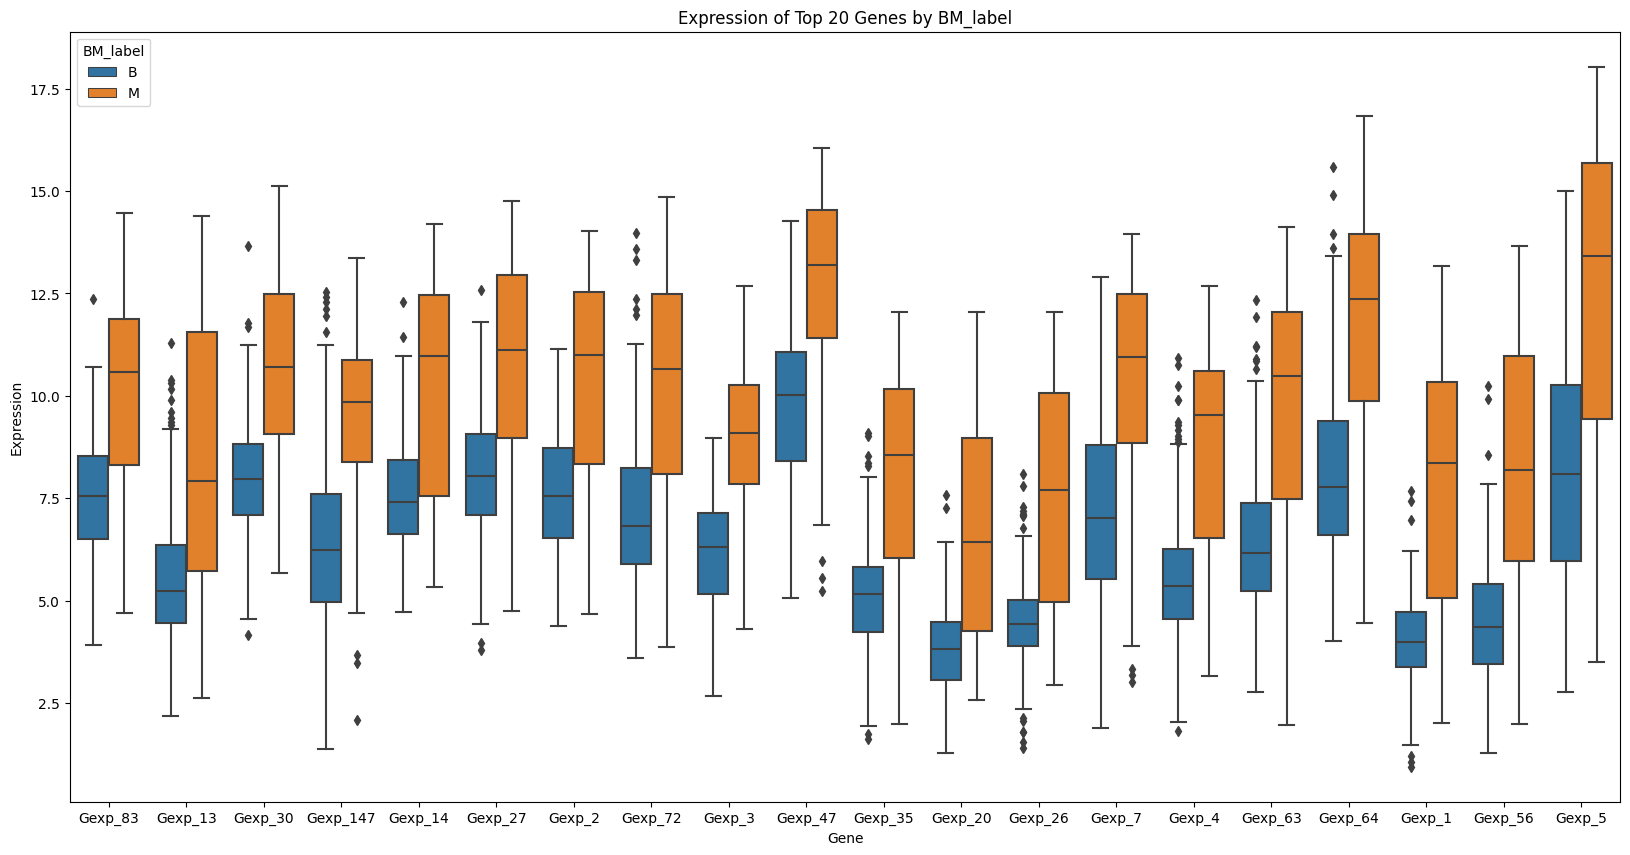

In [141]:
# calculate the absolute difference between the overall centroid and the centroids of each class

centroids=nc_model.centroids_

centroid_abosulte_diff=np.abs(centroids[1]-centroids[0])
centroid_abosulte_diff

#sort the centroid_abosulte_diff by index
sorted_index=np.argsort(centroid_abosulte_diff)

# get the top 20 genes with teh largets absolute difference to the overall centroid
gene_list=df.columns[3:]

top_20_genes_overall=gene_list[sorted_index[-20:]]
top_20_genes_overall

#make a strip plot for the top 20 genes

df_top_20_genes_overall=df[['BM_label']+list(top_20_genes_overall)]
df_top_20_genes_overall=pd.melt(df_top_20_genes_overall, id_vars='BM_label', var_name='Gene', value_name='Expression')

plt.figure(figsize=(20,10))
sns.boxplot(x='Gene', y='Expression', hue='BM_label', data=df_top_20_genes_overall)
plt.xlabel('Gene')
plt.ylabel('Expression')
plt.title('Expression of Top 20 Genes by BM_label')
plt.show()